In [1]:
import os
os.environ["KERAS_BACKEND"] = "tensorflow"
import uproot, pandas
import matplotlib.pyplot as plt
import numpy as np
import scipy
import scipy.optimize 

import matplotlib as mpl
mpl.rcParams['axes.titlesize'] = 16
mpl.rcParams['axes.labelsize'] = 14

In [2]:
def get_pz(fn):
    fi = uproot.open(fn)
    tt = fi.get("Events_all")
    dd = tt.arrays(["GenInitialState_pz_0"])
    return np.log(dd["GenInitialState_pz_0"])

Load the input data, created using the https://gitlab.cern.ch/jpata/higgsmem/ code.

In [3]:
files = {
    "ggh": "../data/out_ggh.root",
    "dyjets": "../data/out_dyjets.root"
}

Get the inital state particle $p_z$ distributions.

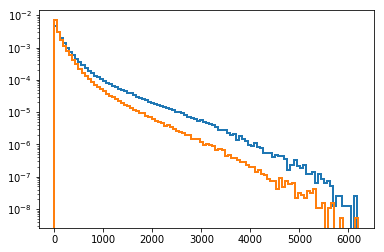

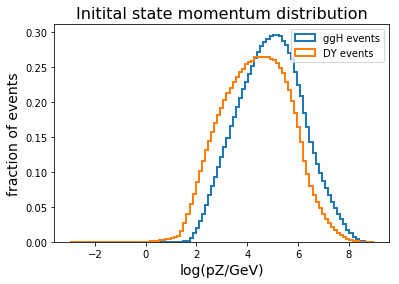

In [4]:
h1 = get_pz(files["ggh"])
h2 = get_pz(files["dyjets"])

plt.figure()
plt.hist(np.exp(h1), bins=100, histtype="step", lw=2, density=1.0);
plt.hist(np.exp(h2), bins=100, histtype="step", lw=2, density=1.0);
plt.yscale("log")

plt.figure()
bins = np.linspace(-3,9, 100)
plt.hist(h1, bins=bins, histtype="step", lw=2, density=1.0, label="ggH events");
plt.hist(h2, bins=bins, histtype="step", lw=2, density=1.0, label="DY events");
plt.xlabel("log(pZ/GeV)")
plt.ylabel("fraction of events")
plt.legend()
plt.title("Initital state momentum distribution")
plt.savefig("./figures/pz_initial.pdf", bbox_inches="tight")

Save the $p_z$ distribution as a ROOT histogram to be loaded in the MEM code. Commented out as it needs a ROOT dependency.

In [5]:
# import ROOT
# of = ROOT.TFile("data/mem_calibration.root", "RECREATE")
# hh1 = ROOT.TH1D("ggh_pdf_logpz", "ggh initial/PDF state log(pz)", 100, -2, 9)
# hh2 = ROOT.TH1D("qqz_pdf_logpz", "qqz initial/PDF state log(pz)", 100, -2, 9)

# hh1.FillN(len(h1), h1.astype(np.double), np.ones_like(h1).astype(np.double))
# hh2.FillN(len(h2), h2.astype(np.double), np.ones_like(h2).astype(np.double))

# of.Write()
# of.Close()

Create the numpy vectors for ML training.

In [6]:
def get_meratio(fn):
    fi = uproot.open(fn)
    tt = fi.get("Events")
    dd = tt.arrays(["me_gen_sig", "me_gen_bkg", "me_reco_sig", "me_reco_bkg", "nGenMediator", "nGenFinalStateMuon", "nMuon", "nMuon_match", "lepton_pair_highest_inv_mass"])
    higgs_window = 30
#    v1 = df[(df["nGenMediator"]==1) & (df["nGenFinalStateMuon"]==2) & (df["nMuon_match"]==2)].eval("log(me_gen_sig/me_gen_bkg)")
    sel = (dd["nGenMediator"]==1) & (dd["nGenFinalStateMuon"]==2) & (dd["nMuon"]==2) & (dd["nMuon_match"]==2) & (abs(dd["lepton_pair_highest_inv_mass"]-125) < higgs_window)
    dd["me_gen_sig"][sel].regular().sum(axis=1)
    v1[(np.isinf(v1)) | (np.isnan(v1))] = 0
    
    v2 = df[(df["nGenMediator"]==1) & (df["nGenFinalStateMuon"]==0) & (df["nMuon"]==2) & (df["nMuon_match"]==0) & (abs(df["lepton_pair_highest_inv_mass"]-125) < higgs_window) & df["me_reco_sig"]>0][["me_reco_sig", "me_reco_bkg", "lep2_highest_inv_mass"]]
    v2["me_reco_sig"] = np.log10(v2["me_reco_sig"])
    v2["me_reco_bkg"] = np.log10(v2["me_reco_bkg"])
    v2[(np.isinf(v2)) | np.isnan(v2)] = 0
    
    v3 = df[(df["nGenMediator"]==1) & (df["nGenFinalStateMuon"]==2) & (df["nMuon"]==2) & (df["nMuon_match"]==2) & (abs(df["lepton_pair_highest_inv_mass"]-125) < higgs_window) & df["me_reco_sig"]>0][["me_reco_sig", "me_reco_bkg", "lep2_highest_inv_mass"]]
    v3["me_reco_sig"] = np.log10(v3["me_reco_sig"])
    v3["me_reco_bkg"] = np.log10(v3["me_reco_bkg"])
    v3[(np.isinf(v3)) | np.isnan(v3)] = 0
    
    return v1, v2, v3

In [7]:
def create_data(filename, higgs_window):
    fi = uproot.open(filename)
    tt = fi.get("Events")
    flat_cols = ["nGenFinalStateMuon", "nMuon", "Muon_px_0", "Muon_py_0", "Muon_pz_0", "Muon_energy_0", "Muon_px_1", "Muon_py_1", "Muon_pz_1", "Muon_energy_1", "lepton_pair_highest_inv_mass"]
    arr_cols = ["me_gen_sig", "me_gen_bkg", "me_reco_sig", "me_reco_bkg"]
    dd = tt.arrays(flat_cols + arr_cols)
    sel = (dd["nGenFinalStateMuon"]==2) & (dd["nMuon"]==2) & (abs(dd["lepton_pair_highest_inv_mass"]-125) < higgs_window)

    data = {}
    for c in flat_cols:
        data[c] = dd[c][sel]

    df = pandas.DataFrame(data)

    for c in arr_cols:
        data[c] = dd[c][sel].regular()


    X = df[["Muon_px_0", "Muon_py_0", "Muon_pz_0", "Muon_energy_0", "Muon_px_1", "Muon_py_1", "Muon_pz_1", "Muon_energy_1"]].values
    z = df[["lepton_pair_highest_inv_mass"]].values
    y = np.log10(data["me_gen_sig"]/data["me_gen_bkg"][:, 0:1])
    yreco = np.log10(data["me_reco_sig"]/data["me_reco_bkg"][:, 0:1])
    z[np.isnan(z)] = 0

    Xmeans = X.mean(axis=0)
    X = X - Xmeans
    Xstds = X.std(axis=0)
    X = X/Xstds

#     ymeans = y.mean(axis=0)
#     y = y - ymeans
#     ystds = y.std(axis=0)
#     y = y/ystds
    
#     ymeans = yreco.mean(axis=0)
#     yreco = yreco - ymeans
#     ystds = yreco.std(axis=0)
#     yreco = yreco/ystds
    return X, y, yreco, z

In [8]:
X_sig, y_sig, yreco_sig, z_sig = create_data(files["ggh"], 30)

In [9]:
X_bkg, y_bkg, yreco_bkg, z_bkg = create_data(files["dyjets"], 30)

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in log10


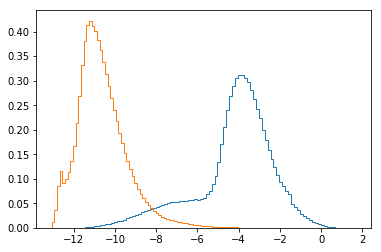

In [10]:
plt.hist(y_sig[:, 46], bins=100, histtype="step", density=1.0);
plt.hist(y_bkg[:, 46], bins=100, histtype="step", density=1.0);

In [11]:
v2_sig = np.log10(np.power(10, y_sig).sum(axis=1))
v2_bkg = np.log10(np.power(10, y_bkg).sum(axis=1))

In [12]:
v2_reco_sig = np.log10(np.power(10, yreco_sig).sum(axis=1))
v2_reco_bkg = np.log10(np.power(10, yreco_bkg).sum(axis=1))

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log10
  


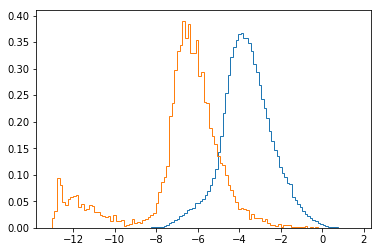

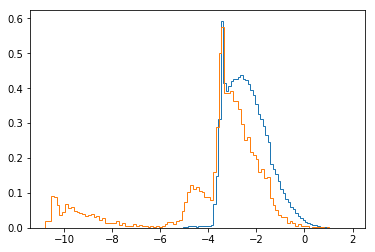

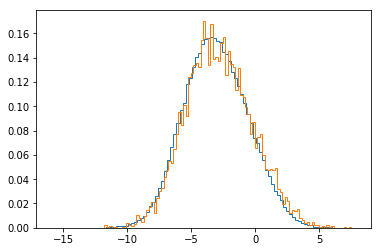

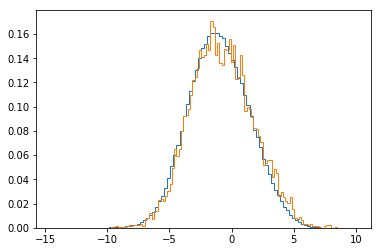

In [13]:
sel_sig = np.abs(z_sig[:, 0] - 125) < 0.5
sel_bkg = np.abs(z_bkg[:, 0] - 125) < 0.5

plt.figure()
plt.hist(y_sig[sel_sig, 46], bins=100, histtype="step", density=1.0);
plt.hist(y_bkg[sel_bkg, 46], bins=100, histtype="step", density=1.0);

plt.figure()
plt.hist(v2_sig[sel_sig], bins=100, histtype="step", density=1.0);
plt.hist(v2_bkg[sel_bkg], bins=100, histtype="step", density=1.0);

plt.figure()
plt.hist(yreco_sig[sel_sig, 46], bins=100, histtype="step", density=1.0);
plt.hist(yreco_bkg[sel_bkg, 46], bins=100, histtype="step", density=1.0);

plt.figure()
plt.hist(v2_reco_sig[sel_sig], bins=100, histtype="step", density=1.0);
plt.hist(v2_reco_bkg[sel_bkg], bins=100, histtype="step", density=1.0);

Save the numpy vectors.

In [14]:
np.savez_compressed("../data/data.npz", X_sig=X_sig, y_sig=y_sig, yreco_sig=yreco_sig, z_sig=z_sig, X_bkg=X_bkg, y_bkg=y_bkg, yreco_bkg=yreco_bkg, z_bkg=z_bkg)